## Reloading data from previous exercice. Please enter the proper path to exercice as the example below.

| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2010-01-01 00:00:00 |     7375 |       2230 |   2560 | 2432   | 16950 |         79.36 |
| 2010-01-04 00:00:00 |     7500 |       2267 |   2574 | 2515   | 17450 |         81.51 |
| 2010-01-05 00:00:00 |     7485 |       2302 |   2575 | 2522.5 | 17375 |         81.77 |
| 2010-01-06 00:00:00 |     7660 |       2377 |   2718 | 2680   | 17825 |         83.18 |
| 2010-01-07 00:00:00 |     7535 |       2310 |   2607 | 2599   | 17475 |         82.66 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2021-01-01 00:00:00 |     7766 |     1979.5 |   2751 |   1994 | 20325 |         48.52 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------

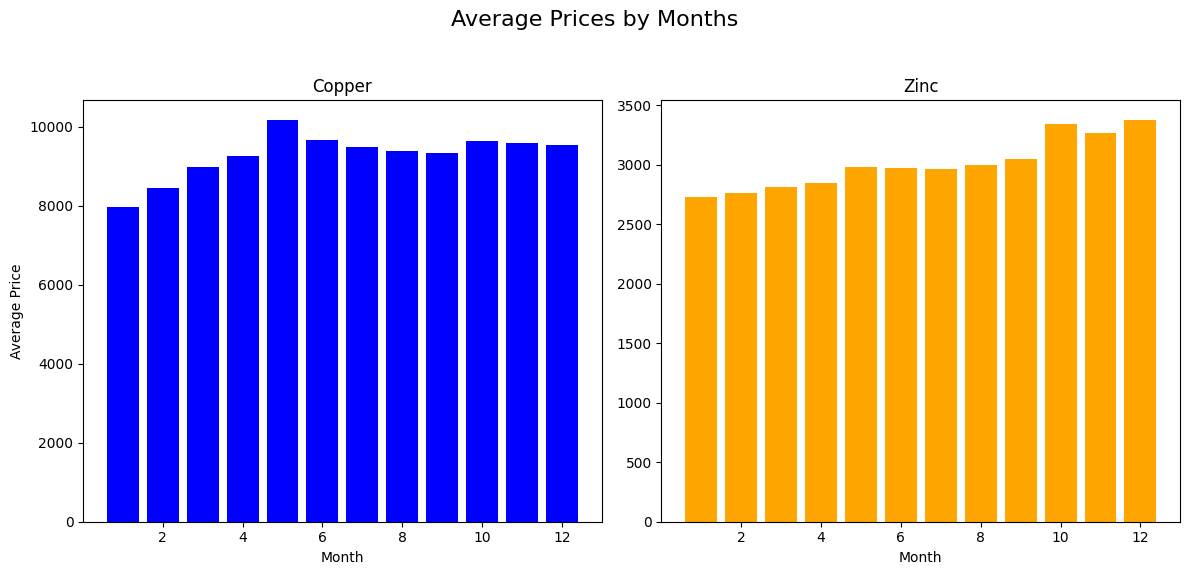

2024-10-04 20:26:40,940 - INFO - Executing add_non_existing_columns
2024-10-04 20:26:40,942 - INFO - Successfully executed add_non_existing_columns in 0.0009 seconds
2024-10-04 20:26:40,953 - INFO - Executing update_indicators


| Date                |   Zinc |   Copper |
|:--------------------|-------:|---------:|
| 2020-01-01 00:00:00 | 2272   |   6174   |
| 2020-01-02 00:00:00 | 2310   |   6188   |
| 2020-01-03 00:00:00 | 2306   |   6129.5 |
| 2020-01-06 00:00:00 | 2324.5 |   6138.5 |
| 2020-01-07 00:00:00 | 2346   |   6149   |


2024-10-04 20:26:41,327 - INFO - Successfully executed update_indicators in 0.3731 seconds
2024-10-04 20:26:41,327 - INFO - Executing update_indicators
2024-10-04 20:26:41,671 - INFO - Successfully executed update_indicators in 0.3439 seconds
2024-10-04 20:26:41,675 - INFO - Executing update_indicators
2024-10-04 20:26:41,832 - INFO - Successfully executed update_indicators in 0.1575 seconds
2024-10-04 20:26:41,833 - INFO - Executing update_indicators
2024-10-04 20:26:41,987 - INFO - Successfully executed update_indicators in 0.1544 seconds


In [104]:
%run "/Users/rayannitcheu/Documents/GitHub/OilDesk-Intern-Assessment/solutions/exercice_3.ipynb"

In [105]:
import numpy as np

from itertools import product
from sklearn.preprocessing import MinMaxScaler

# A First Backtest Strategy

Let's start by defining the setup for our backtest:

* We will test a **naive RSI-based strategy**.
* We will assume **constant transaction costs**.
* The strategy involves buying or selling at the close of day "t," but the exposure will only be applied starting on day "t+1" to prevent look-ahead bias.

## RSI Trading Strategy 

First, we define the following parameters:

1. **Start Date**: The start date of the backtest period.
2. **End Date**: The end date of the backtest period.
3. **Initial Wealth**: The initial value of the portfolio.
4. **RSI Window**: The window size for calculating the RSI indicator.
5. **Buy Threshold**: The RSI level below which we enter a long position.
6. **Short-Sell Threshold**: The RSI level above which we enter a short position.
7. **Leverage**: The exposure level we take on the underlying commodity.

The strategy is as follows:

* On day "t," we observe the RSI:
    * If the RSI is **below the Buy Threshold** → Take a **long position** in the underlying commodity, as it is considered oversold.
    * If the RSI is **above the Short-Sell Threshold** → Take a **short position**, as the commodity is considered overbought.

## Hyperparameter Tuning

We will optimize the strategy using two key criteria:

1. **Sharpe Ratio (SR)**: We prioritize strategies that provide a good trade-off between returns and volatility.
2. **Maximum Drawdown (DD)**: We want strategies with limited drawdowns to manage risk effectively.

To select the best set of parameters, we will use a scoring framework:

* We rank all sets of parameters based on SR and DD, applying a **MinMaxScaler** (e.g., the highest SR gets a score of 1, the median gets 0.5, and the lowest gets 0).
* We then compute a **weighted score** based on a weighting profile provided by the user (e.g., if the user prioritizes Sharpe Ratio, they can set `w_SR = 0.8` and `w_DD = 0.2`). This allows the user to customize their trade-off between SR and DD.

### Note on Overfitting

Due to time constraints, I was unable to implement this feature, but to avoid overfitting during hyperparameter tuning, I would use **K-Fold Cross-Validation**. The process would be:

1. Compute SR and DD on a **training period** and store `SR_train` and `DD_train`.
2. Compute SR and DD on a **test period** and store `SR_test` and `DD_test`.
3. Calculate a score based on SR and DD for both training and test periods (higher values are better), and minimize the difference between `SR_train` vs. `SR_test` and `DD_train` vs. `DD_test` (the lower the difference, the more stable the performance).
4. Select the parameter set with the best overall score.



In [106]:
def rebase_df(p, initial_value):
    """
    This function rebase a given df of prices to begin at an initial value chosen by the user.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = initial_value
    
    return r.cumprod()


def compute_annualized_returns(p):
    """
    This function computes the annualized returns for a given df of prices.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = 1
    r = ((r.fillna(0)).cumprod()).iloc[-1]
    r = r.apply(lambda x: max(x, 1e-6)) # We're setting a floor at 1e-6 else we obtain a wrong return for prices that went to 0.

    return r**(1/252) - 1


def compute_annualized_vol(p):
    """
    This function computes the annualized volatility for a given df of prices.
    """
    
    return p.pct_change().std() * np.sqrt(252)


def compute_dd(p):
    """
    This function computes the maximum drawdown for a given df of prices.
    """
    
    cumulative_max = p.cummax()
    dd = (p - cumulative_max) / cumulative_max
    
    return dd.min()


def compute_annualized_sr(r,
                          v,
                          N):
    """
    This function computes the annualized sharpe ratio for given annualized returns, volatlity and number of days in the strategy.
    """
    
    return np.sqrt(N/252) * r / v


def compute_rolling_returns(p, rolling_window):
    """
    This function computes the rolling returns for a given df of prices and a rolling window.
    """
    
    return p.pct_change(rolling_window)


def compute_rolling_volatility(p, rolling_window):
    """
    This function computes the rolling volatility for a given df of prices and a rolling window.
    """
    
    r = compute_rolling_returns(p, 1)
    
    return r.rolling(rolling_window).std() * np.sqrt(252)


def compute_rolling_sr(rolling_r,
                       rolling_vol,
                       rolling_window):
    
    """
    This function computes the rolling annualized sharpe ratio for given rolling returns, rolling volatility and rolling window.
    """
    
    return np.sqrt(rolling_window/252) * rolling_r / rolling_vol


def compute_rolling_dd(p, rolling_windoww):
    """
    This function computes the rolling rolling DD for  given df of prices and a rolling window.
    """
    
    rolling_max = p.rolling(rolling_windoww).max()
    rolling_dd = ((p - rolling_max) / rolling_max)
    
    return rolling_dd


def compute_statistics(res, print=True):
    """
    This function computes main statistics for a given df of prices and print the summary.
    """
    
    res_df = pd.DataFrame(columns=res.columns, index=["Returns", "Vol", "SR", "DD"])
    res_df.iloc[0] = compute_annualized_returns(res)
    res_df.iloc[1] = compute_annualized_vol(res)
    res_df.iloc[2] = compute_annualized_sr(res_df.iloc[0], res_df.iloc[1], res.shape[0])
    res_df.iloc[3] = compute_dd(res)
    
    if print:
        pretty_print(res_df)

    return res_df

def compute_rolling_statistic(res, rolling_window, plot=True):
    """
    This function compute the rolling statistics for a given df of prices and plot graph for the given rolling window.
    """
    
    # Compute the rolling stats to return
    r = compute_rolling_returns(res, rolling_window)
    v = compute_rolling_volatility(res, rolling_window)
    sr = compute_rolling_sr(r, v, rolling_window)
    dd = compute_rolling_dd(res, rolling_window)
    
    if plot:
        fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))
        fig.suptitle(f'Rolling Statistics with window = {rolling_window} days', fontsize=16)
        
        # Plot Rolling Returns
        axs[0].plot(r.index, r.values, color='blue')
        axs[0].set_title("Rolling Returns")
        
        # Plot Rolling Volatility
        axs[1].plot(v.index, v.values, color='red')
        axs[1].set_title("Rolling Volatility")
        
        # Plot Rolling Sharpe Ratio
        axs[2].plot(sr.index, sr.values, color='green')
        axs[2].set_title("Rolling Sharpe")
        
        # Plot Rolling Drawdown
        axs[3].plot(dd.index, dd.values, color='brown')
        axs[3].set_title("Rolling Drawdown")
        
        # Adjust layout to avoid overlap and make the plot cleaner
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Display the plot
        plt.show()

    return r, v, sr, dd

def plot_df(p, title):
    plt.figure(figsize=(10, 6))

    for col in p.columns:
        plt.plot(p.index, p[col], label=col)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')

    plt.legend(title="Strategies")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_turnover_with_holding(turnover):
    """
    This function takes a df of turnover and plot the result with the mean holding period. 
    """
    
    plt.figure(figsize=(10, 6))

    for col in turnover.columns:
        nb_days_trading = turnover[col][turnover[col] != 0].count()
        
        plt.plot(turnover.index, turnover[col], label=f"{col} Trading Days: {nb_days_trading} days")

    plt.title("Graph of Daily Turnover")
    plt.xlabel('Date')
    plt.ylabel('Turnover')

    plt.legend(title="Strategies")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_returns_distribution(r):
    """
    This function plots the distribution of a given df of returns. 
    """
    
    num_strategies = len(r.columns)
    
    fig, axs = plt.subplots(1, num_strategies, figsize=(5 * num_strategies, 4))
    fig.suptitle("Distribution of Returns for Each Strategy", fontsize=16)
    
    if num_strategies == 1:
        axs = [axs]

    for i, strategy in enumerate(r.columns):
        axs[i].hist(r[strategy], bins=50, color='blue', alpha=0.7)
        axs[i].set_title(strategy)
        axs[i].set_xlabel('Returns')
        axs[i].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()  

def rsi_backtester(prices,
                   plot=False,
                   **kwargs):
    """
    This function takes a df of prices and returns the backtest of a rsi based strategy for each commodities given in input. 
    """
    
    # Those are the default parameters used 
    default_params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  
        'rsi_window': 14,
        'leverage': 1,  
        'long_threshold': 30, 
        'short_threshold': 70,  
    }
    
    # If the user provide a dict of parameters we will update the default params dict
    default_params.update(kwargs)
    
    # Only considering the backtest on dates provided by the parameters dict
    p = prices.copy()
    p = filter_by_dates(p,
                    default_params.get("start_dt"),
                    default_params.get("end_dt"))
    
    # Creating a set of list that will be useful ulteriorly
    commodities_list = p.columns
    rsi_list = [f"{commo}-RSI" for commo in commodities_list]
    strat_list = list()
    strat_tc_list = list()
    signals_list = list()
    turnover_list = list()
    
    # Computing the value of RSI indicator for the commodities
    p = calculate_rsi(p,
                      commodities_list,
                      window=default_params.get("rsi_window"))
    
    
    
    for c, r in zip(commodities_list, rsi_list):

        signal_label = f'{c} Signal'
        turnover_label = f'{c} Turnover'
        rsi_label = f'{c} - RSI Returns'
        rsi_tc_label = f'{c} - RSI TC Returns'

        strat_list.append(rsi_label)
        strat_tc_list.append(rsi_tc_label)
        signals_list.append(signal_label)

        p[signal_label] = p[r]
        
        # Defining the masks to determine buy or sell signal 
        long_mask = (p[signal_label] < default_params.get("long_threshold"))
        short_mask = (p[signal_label] > default_params.get("short_threshold"))
        neutral_mask = (~ long_mask & ~ short_mask)
        
        # Creating the signal 
        p[signal_label][long_mask] = 1 * default_params.get("leverage")
        p[signal_label][short_mask] = - 1 * default_params.get("leverage")
        p[signal_label][neutral_mask] = 0
        
        # Computing the returns for the strategy with and without transaction cost
        # Please note that we're adding a lag to prevent look-ahead bias
        p[signal_label] = p[signal_label].shift(1).fillna(0)
        p[turnover_label] = p[signal_label].diff().abs()
        p[rsi_label] = (1 + p[c].pct_change() * p[signal_label])
        p[rsi_tc_label] = (1 + (p[c].pct_change() * p[signal_label] - p[turnover_label] * default_params.get("tc")))
        
        # Setting the initial value that we will use to compute the performance of strategy  
        p[rsi_label].iloc[default_params.get("rsi_window")] = default_params.get("initial_value")
        p[rsi_tc_label].iloc[default_params.get("rsi_window")] = default_params.get("initial_value")
        
        # Computing the performance of the strategy with and without transaction
        p[rsi_label].iloc[default_params.get("rsi_window"): ] = p[rsi_label].iloc[default_params.get("rsi_window"): ].cumprod()
        p[rsi_tc_label].iloc[default_params.get("rsi_window"):] = p[rsi_tc_label].iloc[default_params.get("rsi_window"):].cumprod()

        # Flooring our wealth at 0
        negative_mask = (p[rsi_label] < 0)
        negative_mask_tc = (p[rsi_tc_label] < 0)

        p[rsi_label][negative_mask] = 0
        p[rsi_tc_label][negative_mask_tc] = 0
    
    # Since RSI is a moving average based indicator we're only keeping the strategy from the moment we have enough data 
    p = p.iloc[default_params.get("rsi_window"):, :]

    # Plotting the result with Plotly to make everything interactive
    if plot:
        plt.figure(figsize=(10, 6))
    
        # Plotting each strategy in strat_list and strat_tc_list
        for strat in strat_list + strat_tc_list:
            plt.plot(p.index, p[strat], label=strat)
    
        # Adding title and labels
        plt.title("Performance of Naive RSI Strategy", fontsize=16)
        plt.xlabel("Dates")
        plt.ylabel("Wealth")
        
        # Adding legend
        plt.legend(loc="best", title="Strategies list with and without TC")
    
        # Displaying the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    return p[strat_list], p[strat_tc_list], p[signals_list], p[turnover_list]

def hyperoptimization(prices, param_grid, w_sr, w_dd):
    """
    This function takes in input a df with a single backtesst and do an hyper-parameter tuning based on sharpe ratio / drawdown tradeoff chosen by the user with the inputs w_sr and w_dd (e.g. for a balanced profile w_sr = 0.5 and w_dd = 0.5.). 
    """
    
    if w_sr + w_dd != 1:    raise ValueError("Sum of the weights should be equal to 100%.")
    
    # Creating the set of all possible parameters combination
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    default_params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  
        'rsi_window': 14,
        'leverage': 1,  
        'long_threshold': 30,
        'short_threshold': 70,
    }

    res_list = list()
    
    # Walking through all the possible combinations.
    for params in param_combinations:
        temp_params = default_params.copy()
        temp_params.update(params)
        
        # Computing the backtest for the chosen dict of parameters
        res, _, _, _ = rsi_backtester(prices, plot=False, **temp_params)
        
        # Computing the sharpe ratio and drawdown , then store them in the list of results
        r = compute_annualized_returns(res)
        v = compute_annualized_vol(res)
        N = res.shape[0]
        sr = compute_rolling_sr(r, v, N)
        dd = compute_dd(res)
        res_list.append({
            'params': params,
            'sr': sr.iloc[0],
            'dd': dd.iloc[0]
        })
        
        
    # Creating a result df with all the results and a score going from 0 to 1 for each sharpe ratio and drawdown
    res_df = pd.DataFrame(res_list)
    scaler = MinMaxScaler()
    res_df[['sr_scaled', 'dd_scaled']] = scaler.fit_transform(res_df[['sr', 'dd']])
    
    # Computing the score given the pofile input by the user
    res_df['final_score'] = w_sr * res_df['sr_scaled'] + w_dd * res_df['dd_scaled']
    default_params.update(res_df.loc[res_df['final_score'].idxmax(), 'params'])
    
    # Return the results 
    res, _, _, _ = rsi_backtester(prices, **default_params)
    stats = compute_statistics(res)

    return default_params, stats, res

## Defining Default Parameters 

We define default parameters which are the usual parameters when defining.

In [107]:
params = {
    'start_dt': clean_data.index[0],
    'end_dt': clean_data.index[-1],
    'initial_value': 1e6,
    'tc': 0.001,
    'rsi_window': 14,
    'leverage': 1,  
    'long_threshold': 30, 
    'short_threshold': 70,
}

## A First Backtest with Default Parameters

Several key observations arise from this initial backtest:

* **Global Performance**: The overall performance with default parameters is quite poor. It is not advisable to use a one-size-fits-all parameter set for all commodities. Instead, the parameters should be fine-tuned for each commodity individually.
* **Performance vs. Benchmark**: The naive strategy with default parameters significantly underperforms compared to the benchmarks. Without proper optimization, it would be more beneficial to simply roll positions in the underlying commodity futures.
* **Regime Switching**: The strategy lacks responsiveness. As illustrated below, the strategy's value dropped to zero when oil futures experienced a rapid sell-off over a short time frame.

In [108]:
res, _, _, _ = rsi_backtester(clean_data,
                              plot=False,
                              **params)

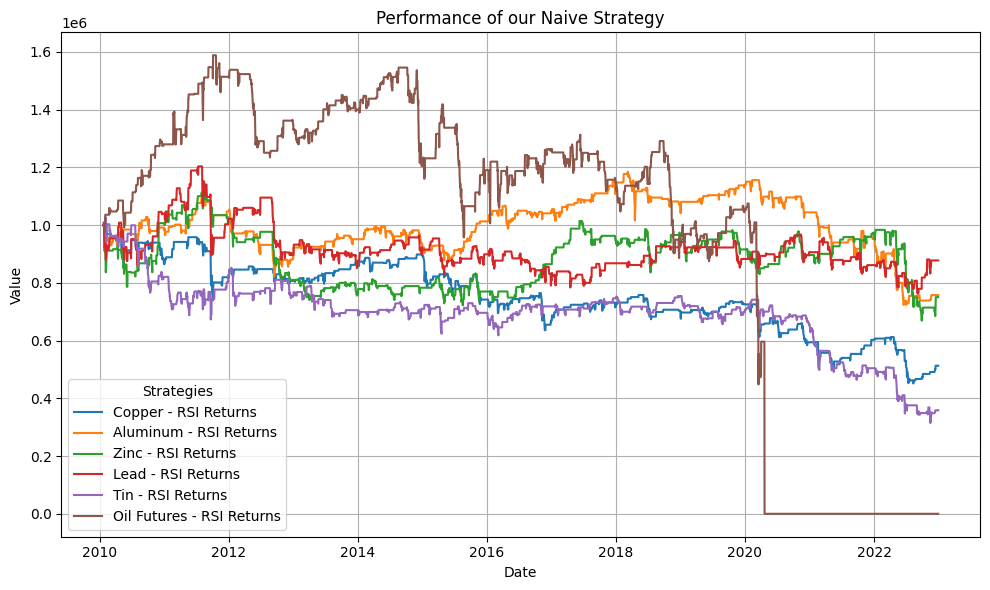

In [109]:
plot_df(res, "Performance of our Naive Strategy")

In [110]:
stats = compute_statistics(res)

|         |   Copper - RSI Returns |   Aluminum - RSI Returns |   Zinc - RSI Returns |   Lead - RSI Returns |   Tin - RSI Returns |   Oil Futures - RSI Returns |
|:--------|-----------------------:|-------------------------:|---------------------:|---------------------:|--------------------:|----------------------------:|
| Returns |            -0.00264617 |              -0.00110092 |          -0.00113767 |         -0.000517444 |         -0.00406083 |                  -0.0533477 |
| Vol     |             0.11537    |               0.104479   |           0.1375     |          0.135919    |          0.156452   |                   0.391872  |
| SR      |            -0.0839638  |              -0.0385737  |          -0.0302885  |         -0.0139364   |         -0.0950165  |                  -0.498353  |
| DD      |            -0.553238   |              -0.389254   |          -0.403105   |         -0.366562    |         -0.693882   |                  -1         |


In [111]:
stats_benchmark = compute_statistics(clean_data)

|         |       Copper |     Aluminum |         Zinc |         Lead |         Tin |   Oil Futures |
|:--------|-------------:|-------------:|-------------:|-------------:|------------:|--------------:|
| Returns |  0.000503289 |  0.000255025 |  0.000593017 | -0.000233516 |  0.00151264 |   4.47506e-05 |
| Vol     |  0.213458    |  0.199751    |  0.251374    |  0.253006    |  0.241947   |   0.994439    |
| SR      |  0.00864905  |  0.00468336  |  0.00865387  | -0.00338571  |  0.022934   |   0.000165076 |
| DD      | -0.57372     | -0.486772    | -0.492168    | -0.448336    | -0.637595   |  -1.33029     |


In [ ]:
backtest_indices = res.index
oil_df = clean_data["Oil Futures"].loc[backtest_indices]
oil_df = pd.concat([res["Oil Futures - RSI Returns"], oil_df], axis=1, ignore_index=False)
oil_df = rebase_df(oil_df, 100)
plot_df(oil_df, "Oil RSI Strategy VS Benchmark")


## Hyperparameters Tuning Process

To demonstrate the hyperparameters tuning process, we will use Aluminum futures as an example. We perform the tuning by applying a grid of parameters with fixed steps and realistic values. For instance, we avoid using unrealistic values like a leverage above 5, as such extreme parameters would likely be a result of outliers or rare events with a low probability of repeating. The goal of this process is to maintain a pragmatic approach to parameter selection.

Through this tuning process, we significantly improved the Sharpe Ratio (SR), achieving a 25-fold increase on Aluminum futures compared to the default parameters. This enhancement makes the strategy more attractive, outperforming the simple strategy of rolling positions in the futures.


In [ ]:
param_grid = {
    'rsi_window': [5, 10, 15, 20, 25],
    'long_threshold': [20, 25, 30, 35, 40],
    'short_threshold': [60, 65, 70, 75, 80],
    'leverage': [0.5, 1, 1.5, 2],
}

In [ ]:
alu_df = clean_data[["Aluminum"]]
w_sr = 0.8
w_dd = 1 - w_sr 


optimized_parameters, optimized_stats, optimized_backtest = hyperoptimization(alu_df, 
                                                                              param_grid,
                                                                              w_sr,
                                                                              w_dd)

In [ ]:
optimized_parameters

In [ ]:
backtest_indices = optimized_backtest.index
compare_df = clean_data["Aluminum"].loc[backtest_indices]
compare_df = pd.concat([optimized_backtest, alu_df], axis=1, ignore_index=False)
compare_df = rebase_df(compare_df, 1)
plot_df(compare_df, "Optimized Aluminum RSI Strategy VS Benchmark")

In [ ]:
_, _, _, _ = compute_rolling_statistic(optimized_backtest, 252, plot=True)

In [ ]:
optimized_stats.loc["SR"]["Aluminum - RSI Returns"] / stats_benchmark.loc["SR"]["Aluminum"]



## Ideas of Improvements for the RSI Strategy

To enhance the performance and reactivity of the basic RSI strategy, we propose adding layers of responsiveness. The goal is to make the strategy more reactive to market movements without overcomplicating the structure. We will adapt the concept of multiple timeframes and thresholds, but with the RSI indicator, as follows:

We define two RSI signals:
- **Short-term RSI Signal (SRSI)**: Calculated using a shorter lookback window for the RSI (e.g., 14 days).
- **Long-term RSI Signal (LRSI)**: Calculated using a longer lookback window (e.g., 50 days).

The combination of these two signals will help capture both short-term market volatility and longer-term trends.

### Signal Construction

The strategy works as follows:

- If the **Short-term RSI** is below the Buy Threshold and the **Long-term RSI** is also below the Buy Threshold, we consider the asset oversold in both timeframes, indicating a stronger buy signal.
- Similarly, if both the **Short-term RSI** and the **Long-term RSI** are above the Sell Threshold, we interpret it as a stronger signal to short the asset.
- If the two signals disagree (one indicating buy and the other indicating sell), no position is opened to avoid mixed signals.

### Global Signal

We then create a **Global RSI Signal (GRSI)**, which combines the short- and long-term RSI signals:

- If **SRSI** and **LRSI** are both signaling a buy or sell, the **GRSI** will take a value of 1 or -1, respectively.
- If they disagree, the **GRSI** will take a neutral value of 0.

This signal is then compared to a **Minimum Signal Threshold (MinRSI)**, which dictates when we open or close positions.

### Trading Rules

1. **When no position is open**:
   - If **GRSI ≥ MinRSI** → we open a position. For this strategy, we set **MinRSI = 0**, so any positive signal triggers a trade.
  
2. **When a position is open**:
   - If **GRSI ≤ MinRSI** → we close the position. Again, with **MinRSI = 0**, a neutral or negative signal will close the trade.

By incorporating both short-term and long-term RSIs, the strategy becomes more reactive to market changes without over-trading. The short-term RSI adds reactivity, improving performance, while the long-term RSI ensures we stay in line with broader market trends, reducing the risk of false signals.
